In [1]:
import os
import pickle
import sqlite3

import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from repositories.stocks import StockRepository

from repositories.income_statement import IncomeStatementRepository
from repositories.balance_sheet import BalanceSheetRepository
from repositories.cash_flow import CashFlowRepository
from repositories.earnings import EarningsRepository
from datetime import datetime, timedelta

In [2]:
conn = sqlite3.connect('../data/stockup.db')
income_statement_repo = IncomeStatementRepository(conn)
balance_sheet_repo = BalanceSheetRepository(conn)
cash_flow_repo = CashFlowRepository(conn)
earnings_repo = EarningsRepository(conn)
stock_repo = StockRepository(conn)

In [3]:
ticker = 'RTX'
income_data = income_statement_repo.find_all(symbol=ticker, limit=1_000_000)
balance_data = balance_sheet_repo.find_all(symbol=ticker, limit=1_000_000)
cash_data = cash_flow_repo.find_all(symbol=ticker, limit=1_000_000)
earnings_data = earnings_repo.find_all(symbol=ticker, limit=1_000_000)

In [4]:
income_df = pd.DataFrame(income_data)
income_df.set_index('fiscalDateEnding', inplace=True)
income_df.sample(10)

,symbol,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome,report_type
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2020-03-31,RTX,USD,2.788000e+09,1.136000e+10,8.572000e+09,1.340800e+10,1.295000e+09,9.770000e+08,5.350000e+08,3.269000e+09,...,3.540000e+08,5.560000e+08,639000000.0,3.800000e+08,4.380000e+08,-1.724000e+09,8.880000e+08,1.242000e+09,-8.300000e+07,quarterlyReports
2019-12-31,RTX,USD,1.075100e+10,4.534900e+10,3.459800e+10,5.706500e+10,4.914000e+09,3.711000e+09,2.452000e+09,1.345300e+10,...,1.452000e+09,5.958000e+09,421000000.0,1.611000e+09,3.510000e+09,5.464000e+09,7.549000e+09,9.001000e+09,5.537000e+09,annualReports
2023-06-30,RTX,USD,1.661700e+10,1.831500e+10,1.698000e+09,1.451800e+10,1.458000e+09,1.635000e+09,7.290000e+08,2.874000e+09,...,5.100000e+08,1.540000e+09,213000000.0,3.330000e+08,1.327000e+09,1.814000e+09,1.873000e+09,2.383000e+09,1.327000e+09,quarterlyReports
2020-12-31,RTX,USD,2.153000e+09,1.641900e+10,1.426600e+10,1.426600e+10,1.420000e+08,1.351000e+09,7.100000e+08,-2.860000e+08,...,6.190000e+08,-4.300000e+07,-178000000.0,3.490000e+08,1.460000e+08,4.413000e+09,3.060000e+08,9.250000e+08,1.350000e+08,quarterlyReports
2019-12-31,RTX,USD,2.578000e+09,1.169400e+10,9.116000e+09,1.473400e+10,9.560000e+08,1.039000e+09,6.680000e+08,3.678000e+09,...,3.610000e+08,1.099000e+09,-44000000.0,4.190000e+08,6.570000e+08,1.811000e+09,1.516000e+09,1.877000e+09,1.143000e+09,quarterlyReports
2021-03-31,RTX,USD,1.388300e+10,1.525100e+10,1.368000e+09,1.253700e+10,1.013000e+09,1.220000e+09,5.890000e+08,2.428000e+09,...,5.960000e+08,1.098000e+09,345000000.0,3.460000e+08,7.720000e+08,5.660000e+08,1.444000e+09,2.040000e+09,7.530000e+08,quarterlyReports
2021-09-30,RTX,USD,1.483400e+10,1.621300e+10,1.379000e+09,1.308900e+10,1.343000e+09,1.229000e+09,6.760000e+08,2.546000e+09,...,6.220000e+08,1.396000e+09,3000000.0,3.580000e+08,1.400000e+09,1.009000e+09,1.754000e+09,2.376000e+09,1.393000e+09,quarterlyReports
2022-09-30,RTX,USD,1.553100e+10,1.695100e+10,1.420000e+09,1.346400e+10,1.520000e+09,1.351000e+09,6.620000e+08,2.550000e+09,...,4.970000e+08,1.629000e+09,282000000.0,3.110000e+08,1.387000e+09,1.960000e+08,1.940000e+09,2.437000e+09,1.387000e+09,quarterlyReports
2018-12-31,RTX,USD,4.297000e+09,1.804400e+10,1.374700e+10,1.374700e+10,-3.765000e+09,-2.287000e+09,1.490000e+08,3.177000e+09,...,2.960000e+08,1.480000e+08,-538000000.0,3.170000e+08,-3.367000e+09,-9.240000e+08,4.590000e+08,7.550000e+08,6.860000e+08,quarterlyReports


In [5]:
income_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2018-12-31 to 2023-09-30
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   symbol                             25 non-null     object 
 1   reportedCurrency                   25 non-null     object 
 2   grossProfit                        25 non-null     float64
 3   totalRevenue                       25 non-null     float64
 4   costOfRevenue                      25 non-null     float64
 5   costofGoodsAndServicesSold         25 non-null     float64
 6   operatingIncome                    25 non-null     float64
 7   sellingGeneralAndAdministrative    25 non-null     float64
 8   researchAndDevelopment             25 non-null     float64
 9   operatingExpenses                  25 non-null     float64
 10  investmentIncomeNet                25 non-null     float64
 11  netInterestIncome                  25 no

In [6]:
income_df.describe()

,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,netInterestIncome,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
count,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,25.0,2.500000e+01,...,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01
mean,1.373776e+10,2.274136e+10,9.003600e+09,2.121316e+10,1.106400e+09,1.855040e+09,1.006800e+09,4.581840e+09,0.0,-5.428000e+08,...,3.029600e+08,7.531600e+08,1.430960e+09,2.372800e+08,5.947200e+08,7.458400e+08,1.388960e+09,1.970200e+09,2.723360e+09,1.195280e+09
std,1.509206e+10,1.684623e+10,1.115352e+10,1.582974e+10,2.200807e+09,1.674519e+09,7.696948e+08,3.637335e+09,0.0,4.080660e+08,...,6.415284e+08,5.873087e+08,2.390152e+09,3.596609e+08,4.759435e+08,2.013374e+09,2.423337e+09,2.621597e+09,2.934770e+09,2.198217e+09
min,1.743000e+09,1.095300e+10,1.368000e+09,1.221400e+10,-3.765000e+09,-2.287000e+09,1.490000e+08,-2.860000e+08,0.0,-1.611000e+09,...,0.000000e+00,2.960000e+08,-3.873000e+09,-5.380000e+08,3.110000e+08,-3.844000e+09,-4.728000e+09,-3.538000e+09,-2.938000e+09,-3.835000e+09
25%,2.788000e+09,1.406100e+10,1.476000e+09,1.300400e+10,9.560000e+08,1.229000e+09,6.350000e+08,2.591000e+09,0.0,-4.190000e+08,...,0.000000e+00,4.670000e+08,5.560000e+08,6.000000e+06,3.330000e+08,4.380000e+08,2.230000e+08,8.880000e+08,1.365000e+09,6.860000e+08
50%,1.388300e+10,1.631400e+10,5.862000e+09,1.370700e+10,1.320000e+09,1.401000e+09,6.950000e+08,2.892000e+09,0.0,-3.500000e+08,...,0.000000e+00,5.450000e+08,1.396000e+09,2.130000e+08,3.580000e+08,1.040000e+09,1.398000e+09,1.754000e+09,2.260000e+09,1.148000e+09
75%,1.553100e+10,1.809300e+10,1.221400e+10,1.452600e+10,1.501000e+09,1.811000e+09,7.290000e+08,3.678000e+09,0.0,-3.290000e+08,...,0.000000e+00,6.190000e+08,1.726000e+09,3.970000e+08,4.310000e+08,1.387000e+09,2.710000e+09,2.041000e+09,2.548000e+09,1.422000e+09
max,6.134300e+10,6.707400e+10,4.805600e+10,5.706500e+10,5.414000e+09,5.663000e+09,2.732000e+09,1.345300e+10,0.0,-2.760000e+08,...,1.843000e+09,2.439000e+09,6.367000e+09,1.098000e+09,1.971000e+09,5.216000e+09,5.683000e+09,7.549000e+09,9.130000e+09,5.537000e+09


In [7]:
annual_income_statements = income_df[income_df['report_type'] == 'annualReports']
quarterly_income_statements = income_df[income_df['report_type'] == 'quarterlyReports']

In [8]:
annual_income_statements

,symbol,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome,report_type
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2018-12-31,RTX,USD,1.651600e+10,3.470100e+10,1.818500e+10,4.998500e+10,2.877000e+09,2.864000e+09,1.878000e+09,1.092300e+10,...,9.760000e+08,6.367000e+09,1.098000e+09,1.038000e+09,1.216000e+09,3.461000e+09,7.399000e+09,8.375000e+09,5.269000e+09,annualReports
2019-12-31,RTX,USD,1.075100e+10,4.534900e+10,3.459800e+10,5.706500e+10,4.914000e+09,3.711000e+09,2.452000e+09,1.345300e+10,...,1.452000e+09,5.958000e+09,4.210000e+08,1.611000e+09,3.510000e+09,5.464000e+09,7.549000e+09,9.001000e+09,5.537000e+09,annualReports
2020-12-31,RTX,USD,8.531000e+09,5.658700e+10,4.805600e+10,4.805600e+10,-1.889000e+09,5.540000e+09,2.582000e+09,1.141200e+10,...,2.125000e+09,-2.944000e+09,5.750000e+08,1.366000e+09,-3.109000e+09,-9.790000e+08,-1.578000e+09,5.470000e+08,-3.519000e+09,annualReports
2021-12-31,RTX,USD,5.852600e+10,6.438800e+10,5.862000e+09,5.189700e+10,4.958000e+09,5.224000e+09,2.732000e+09,1.049100e+10,...,2.439000e+09,4.650000e+09,7.860000e+08,1.971000e+09,3.897000e+09,5.683000e+09,5.972000e+09,8.411000e+09,3.864000e+09,annualReports
2022-12-31,RTX,USD,6.134300e+10,6.707400e+10,5.731000e+09,5.340600e+10,5.414000e+09,5.663000e+09,2.711000e+09,1.035700e+10,...,1.957000e+09,5.897000e+09,7.000000e+08,1.276000e+09,5.216000e+09,5.094000e+09,7.173000e+09,9.130000e+09,5.197000e+09,annualReports


In [9]:
quarterly_income_statements

,symbol,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,...,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome,report_type
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2018-12-31,RTX,USD,4.297000e+09,1.804400e+10,1.374700e+10,1.374700e+10,-3.765000e+09,-2.287000e+09,149000000.0,3.177000e+09,...,296000000.0,1.480000e+08,-538000000.0,317000000.0,-3.367000e+09,-9.240000e+08,4.590000e+08,7.550000e+08,6.860000e+08,quarterlyReports
2019-03-31,RTX,USD,2.534000e+09,1.095300e+10,8.419000e+09,1.370700e+10,1.142000e+09,1.997000e+09,728000000.0,3.220000e+09,...,374000000.0,1.743000e+09,397000000.0,431000000.0,7.120000e+08,1.905000e+09,2.174000e+09,2.548000e+09,1.346000e+09,quarterlyReports
2019-06-30,RTX,USD,2.775000e+09,1.132900e+10,8.554000e+09,1.441300e+10,1.386000e+09,9.020000e+08,605000000.0,3.197000e+09,...,348000000.0,1.906000e+09,6000000.0,360000000.0,1.183000e+09,1.525000e+09,2.258000e+09,2.606000e+09,1.900000e+09,quarterlyReports
2019-09-30,RTX,USD,2.864000e+09,1.137300e+10,8.509000e+09,1.421100e+10,1.430000e+09,9.020000e+08,592000000.0,3.205000e+09,...,369000000.0,1.454000e+09,306000000.0,401000000.0,9.580000e+08,2.230000e+08,1.856000e+09,2.225000e+09,1.148000e+09,quarterlyReports
2019-12-31,RTX,USD,2.578000e+09,1.169400e+10,9.116000e+09,1.473400e+10,9.560000e+08,1.039000e+09,668000000.0,3.678000e+09,...,361000000.0,1.099000e+09,-44000000.0,419000000.0,6.570000e+08,1.811000e+09,1.516000e+09,1.877000e+09,1.143000e+09,quarterlyReports
2020-03-31,RTX,USD,2.788000e+09,1.136000e+10,8.572000e+09,1.340800e+10,1.295000e+09,9.770000e+08,535000000.0,3.269000e+09,...,354000000.0,5.560000e+08,639000000.0,380000000.0,4.380000e+08,-1.724000e+09,8.880000e+08,1.242000e+09,-8.300000e+07,quarterlyReports
2020-06-30,RTX,USD,1.847000e+09,1.406100e+10,1.221400e+10,1.221400e+10,-3.760000e+09,1.811000e+09,695000000.0,6.716000e+09,...,600000000.0,-3.873000e+09,-38000000.0,335000000.0,-3.844000e+09,-4.728000e+09,-3.538000e+09,-2.938000e+09,-3.835000e+09,quarterlyReports
2020-09-30,RTX,USD,1.743000e+09,1.474700e+10,1.300400e+10,1.300400e+10,4.340000e+08,1.401000e+09,642000000.0,2.892000e+09,...,599000000.0,4.160000e+08,152000000.0,350000000.0,1.510000e+08,1.052000e+09,7.660000e+08,1.365000e+09,2.640000e+08,quarterlyReports
2020-12-31,RTX,USD,2.153000e+09,1.641900e+10,1.426600e+10,1.426600e+10,1.420000e+08,1.351000e+09,710000000.0,-2.860000e+08,...,619000000.0,-4.300000e+07,-178000000.0,349000000.0,1.460000e+08,4.413000e+09,3.060000e+08,9.250000e+08,1.350000e+08,quarterlyReports


#### INCOME STATEMENT

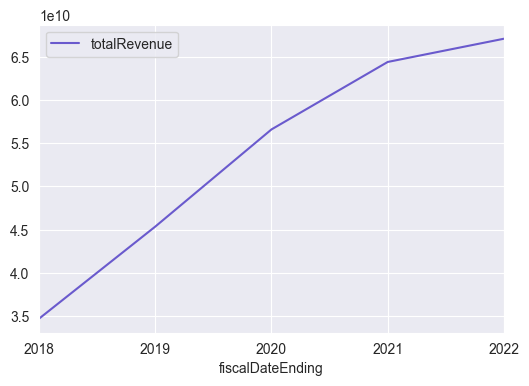

In [10]:
plot_MTC_annual_reports = annual_income_statements.plot(
    kind='line',
    y='totalRevenue',
    color='slateblue',
    figsize=(6, 4),
    use_index=True
)

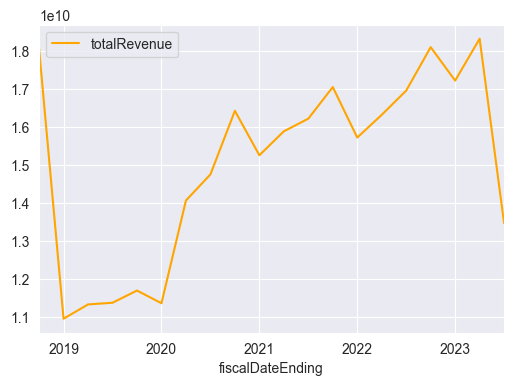

In [11]:
plot_MTC_quarterly_reports = quarterly_income_statements.plot(
    kind='line',
    y='totalRevenue',
    color='orange',
    figsize=(6, 4),
    use_index=True
)

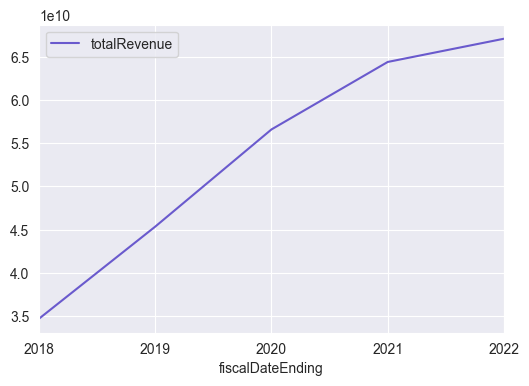

In [12]:
plot_totalRevenue_annual = annual_income_statements.plot(
    kind='line',
    y='totalRevenue',
    color='slateblue',
    figsize=(6, 4),
    use_index=True
)

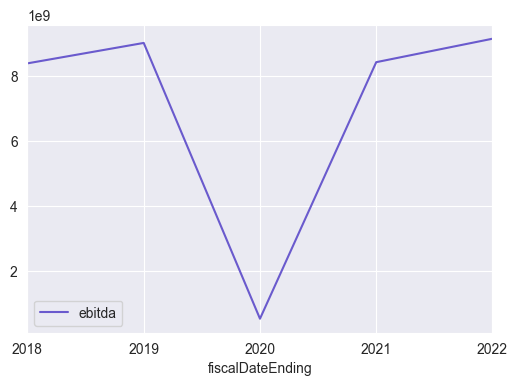

In [13]:
plot_ebitda_annual = annual_income_statements.plot(
    kind='line',
    y='ebitda',
    color='slateblue',
    figsize=(6, 4),
    use_index=True
)

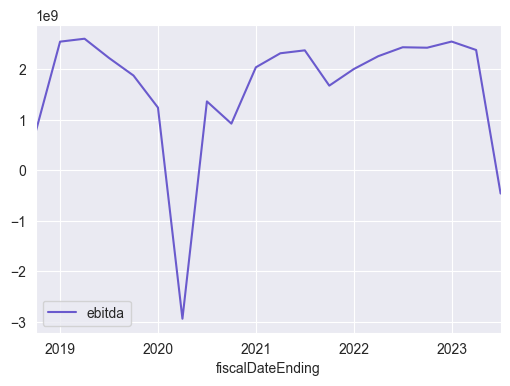

In [14]:
plot_ebitda_quarterly = quarterly_income_statements.plot(
    kind='line',
    y='ebitda',
    color='slateblue',
    figsize=(6, 4),
    use_index=True
)

/var/folders/4_/6kjv3ltd50q381qfm5bjrbqh0000gn/T/ipykernel_34454/2798578249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_income_statements['gross_profit_margin'] = annual_income_statements['grossProfit'] / annual_income_statements[


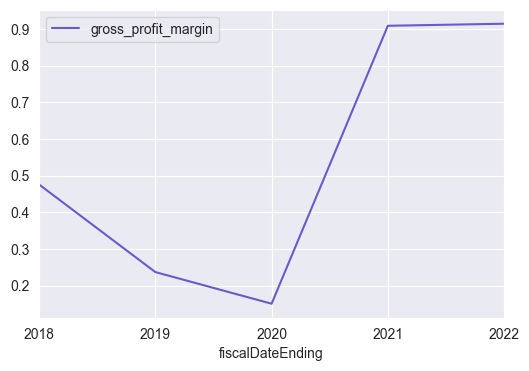

In [15]:
annual_income_statements['gross_profit_margin'] = annual_income_statements['grossProfit'] / annual_income_statements[
    'totalRevenue']
plot_gross_profit_margin = annual_income_statements.plot(
    kind='line',
    y='gross_profit_margin',
    color='slateblue',
    figsize=(6, 4),
    use_index=True
)

/var/folders/4_/6kjv3ltd50q381qfm5bjrbqh0000gn/T/ipykernel_34454/3886446904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_income_statements['net_profit_margin'] = annual_income_statements['netIncome'] / annual_income_statements[


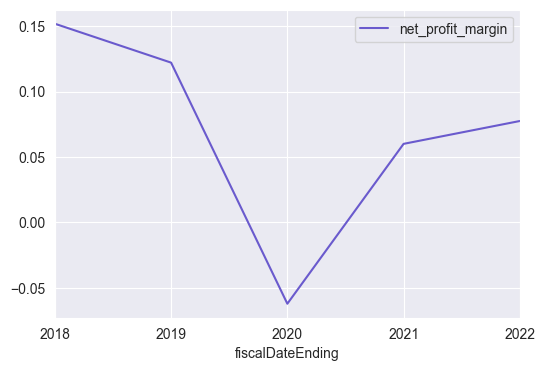

In [16]:
annual_income_statements['net_profit_margin'] = annual_income_statements['netIncome'] / annual_income_statements[
    'totalRevenue']
plot_gross_profit_margin = annual_income_statements.plot(
    kind='line',
    y='net_profit_margin',
    color='slateblue',
    figsize=(6, 4),
    use_index=True
)

#### BALANCE SHEET

In [17]:
balance_sheet_df = pd.DataFrame(balance_data)
balance_sheet_df.set_index('fiscalDateEnding', inplace=True)
balance_sheet_df.sample(10)

,symbol,reportedCurrency,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,...,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStock,commonStockSharesOutstanding,period
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2022-03-31,RTX,USD,1.593660e+11,4.074000e+10,6.040000e+09,6.897000e+09,9.749000e+09,9.076000e+09,1.186260e+11,1.483700e+10,...,0.0,3.174000e+10,1.288400e+10,9.643000e+09,7.246200e+10,1.348300e+10,5.059200e+10,3.750400e+10,1.486800e+09,quarterlyReports
2021-12-31,RTX,USD,1.614040e+11,4.205000e+10,7.832000e+09,8.797000e+09,9.178000e+09,9.661000e+09,1.165060e+11,1.497200e+10,...,0.0,3.148500e+10,1.282000e+10,1.041700e+10,7.306800e+10,1.272700e+10,5.026500e+10,3.744500e+10,1.491400e+09,quarterlyReports
2018-12-31,RTX,USD,1.342110e+11,3.550300e+10,3.693000e+09,6.152000e+09,1.008300e+10,1.427100e+10,9.518100e+10,1.229700e+10,...,0.0,4.553700e+10,1.022300e+10,1.184500e+10,3.844600e+10,3.248200e+10,5.782300e+10,2.243800e+10,8.298000e+08,quarterlyReports
2023-06-30,RTX,USD,1.621610e+11,4.591500e+10,5.391000e+09,6.110000e+09,1.199700e+10,9.903000e+09,1.162460e+11,1.529500e+10,...,0.0,3.561500e+10,1.384000e+10,7.442000e+09,7.248000e+10,1.671300e+10,5.248900e+10,3.820600e+10,1.457500e+09,quarterlyReports
2020-09-30,RTX,USD,1.623990e+11,4.351100e+10,1.000100e+10,1.000100e+10,9.843000e+09,1.011500e+10,1.188880e+11,1.473000e+10,...,0.0,5.270000e+08,1.367600e+10,9.142000e+09,6.837900e+10,1.040700e+10,5.001700e+10,3.678100e+10,1.511500e+09,quarterlyReports
2022-12-31,RTX,USD,1.588640e+11,4.244300e+10,6.220000e+09,6.994000e+09,1.061700e+10,9.108000e+09,1.138180e+11,1.517000e+10,...,0.0,3.191400e+10,1.340000e+10,8.449000e+09,7.263200e+10,1.553000e+10,5.226900e+10,3.791100e+10,1.465900e+09,quarterlyReports
2019-09-30,RTX,USD,1.390090e+11,3.781600e+10,4.983000e+09,7.341000e+09,1.124200e+10,1.360700e+10,1.009120e+11,1.220000e+10,...,0.0,1.913000e+09,1.167200e+10,1.677400e+10,4.046800e+10,3.258800e+10,6.106900e+10,2.280600e+10,8.551000e+08,quarterlyReports
2023-09-30,RTX,USD,1.624430e+11,4.651800e+10,5.456000e+09,6.193000e+09,1.205000e+10,1.005800e+10,1.159250e+11,1.534700e+10,...,0.0,3.552000e+10,1.688000e+10,7.514000e+09,6.959600e+10,1.817000e+10,5.151300e+10,3.836900e+10,1.448100e+09,quarterlyReports
2022-09-30,RTX,USD,1.582250e+11,4.182100e+10,5.381000e+09,6.121000e+09,1.044300e+10,9.233000e+09,1.164040e+11,1.466800e+10,...,0.0,3.370300e+10,1.360000e+10,8.124000e+09,7.018700e+10,1.514100e+10,5.165200e+10,3.782900e+10,1.470100e+09,quarterlyReports


In [18]:
balance_sheet_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2018-12-31 to 2023-09-30
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   symbol                                  25 non-null     object 
 1   reportedCurrency                        25 non-null     object 
 2   totalAssets                             25 non-null     float64
 3   totalCurrentAssets                      25 non-null     float64
 4   cashAndCashEquivalentsAtCarryingValue   25 non-null     float64
 5   cashAndShortTermInvestments             25 non-null     float64
 6   inventory                               25 non-null     float64
 7   currentNetReceivables                   25 non-null     float64
 8   totalNonCurrentAssets                   25 non-null     float64
 9   propertyPlantEquipment                  25 non-null     float64
 10  accumulatedDepreciationAmortizationPPE  25 n

In [19]:
balance_sheet_df.describe()

,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,accumulatedDepreciationAmortizationPPE,intangibleAssets,...,currentLongTermDebt,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStock,commonStockSharesOutstanding
count,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,...,2.500000e+01,25.0,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01
mean,1.532971e+11,4.288868e+10,6.341680e+09,7.508600e+09,1.020428e+10,1.051540e+10,1.109216e+11,1.392512e+10,1.244972e+10,8.368428e+10,...,1.643360e+09,0.0,2.449480e+10,1.274936e+10,1.019912e+10,6.136940e+10,1.949688e+10,5.369584e+10,3.275124e+10,1.281408e+09
std,1.098092e+10,6.404605e+09,1.695634e+09,1.342908e+09,9.038800e+08,1.917992e+09,8.774846e+09,1.578528e+09,1.437323e+09,1.609046e+10,...,1.652051e+09,0.0,1.686610e+10,1.522887e+09,2.821675e+09,1.497240e+10,9.381979e+09,4.652562e+09,7.031837e+09,3.030826e+08
min,1.342110e+11,3.540200e+10,3.693000e+09,5.555000e+09,9.047000e+09,8.743000e+09,9.518100e+10,1.032200e+10,9.755000e+09,2.560000e+10,...,2.400000e+07,0.0,4.690000e+08,1.022300e+10,7.414000e+09,3.844600e+10,1.039800e+10,4.895400e+10,2.243800e+10,8.298000e+08
25%,1.396150e+11,4.074000e+10,4.983000e+09,6.240000e+09,9.426000e+09,9.233000e+09,1.009120e+11,1.229700e+10,1.178700e+10,7.453600e+10,...,5.500000e+08,0.0,1.913000e+09,1.173700e+10,8.449000e+09,4.177400e+10,1.239800e+10,5.026500e+10,2.295500e+10,8.566000e+08
50%,1.588640e+11,4.205000e+10,6.040000e+09,6.994000e+09,1.008300e+10,9.661000e+09,1.159250e+11,1.474100e+10,1.244900e+10,9.066300e+10,...,1.362000e+09,0.0,3.174000e+10,1.282000e+10,9.537000e+09,7.044100e+10,1.553000e+10,5.165200e+10,3.695100e+10,1.465900e+09
75%,1.615170e+11,4.337600e+10,7.832000e+09,8.797000e+09,1.061700e+10,1.039400e+10,1.167800e+11,1.497200e+10,1.324900e+10,9.295200e+10,...,2.876000e+09,0.0,3.473800e+10,1.352300e+10,1.041700e+10,7.246200e+10,3.248200e+10,5.782300e+10,3.767300e+10,1.497300e+09
max,1.624430e+11,6.157700e+10,1.000100e+10,1.000100e+10,1.205000e+10,1.427100e+10,1.192430e+11,1.534700e+10,1.520700e+10,9.527200e+10,...,6.202000e+09,0.0,4.553700e+10,1.688000e+10,1.705200e+10,7.306800e+10,3.266500e+10,6.159400e+10,3.836900e+10,1.511500e+09


In [20]:
annual_balance_sheet_statements = balance_sheet_df[balance_sheet_df['period'] == 'annualReports']
quarterly_balance_sheet_statements = balance_sheet_df[balance_sheet_df['period'] == 'quarterlyReports']

In [21]:
annual_balance_sheet_statements

,symbol,reportedCurrency,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,...,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStock,commonStockSharesOutstanding,period
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2018-12-31,RTX,USD,1.342110e+11,3.550300e+10,3.693000e+09,6.152000e+09,1.008300e+10,1.427100e+10,9.518100e+10,1.229700e+10,...,0.0,4.553700e+10,1.022300e+10,1.184500e+10,3.844600e+10,3.248200e+10,5.782300e+10,2.243800e+10,8.298000e+08,annualReports
2019-12-31,RTX,USD,1.396150e+11,6.157700e+10,4.937000e+09,7.378000e+09,9.047000e+09,8.743000e+09,9.852400e+10,1.032200e+10,...,0.0,4.325200e+10,1.173700e+10,7.414000e+09,4.177400e+10,3.262600e+10,6.159400e+10,2.295500e+10,8.566000e+08,annualReports
2020-12-31,RTX,USD,1.621530e+11,4.337600e+10,8.802000e+09,9.683000e+09,9.411000e+09,9.254000e+09,1.156330e+11,1.496200e+10,...,0.0,3.182300e+10,1.352300e+10,9.537000e+09,7.216300e+10,1.040700e+10,4.942300e+10,3.688100e+10,1.497300e+09,annualReports
2021-12-31,RTX,USD,1.614040e+11,4.205000e+10,7.832000e+09,8.797000e+09,9.178000e+09,9.661000e+09,1.165060e+11,1.497200e+10,...,0.0,3.148500e+10,1.282000e+10,1.041700e+10,7.306800e+10,1.272700e+10,5.026500e+10,3.744500e+10,1.491400e+09,annualReports
2022-12-31,RTX,USD,1.588640e+11,4.244300e+10,6.220000e+09,6.994000e+09,1.061700e+10,9.108000e+09,1.138180e+11,1.517000e+10,...,0.0,3.191400e+10,1.340000e+10,8.449000e+09,7.263200e+10,1.553000e+10,5.226900e+10,3.791100e+10,1.465900e+09,annualReports


In [22]:
quarterly_balance_sheet_statements

,symbol,reportedCurrency,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,...,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStock,commonStockSharesOutstanding,period
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2018-12-31,RTX,USD,1.342110e+11,3.550300e+10,3.693000e+09,6.152000e+09,1.008300e+10,1.427100e+10,9.518100e+10,1.229700e+10,...,0.0,4.553700e+10,1.022300e+10,1.184500e+10,3.844600e+10,3.248200e+10,5.782300e+10,2.243800e+10,8.298000e+08,quarterlyReports
2019-03-31,RTX,USD,1.373800e+11,3.540200e+10,6.240000e+09,6.240000e+09,1.047400e+10,1.357400e+10,9.895100e+10,1.221000e+10,...,0.0,1.751000e+09,1.075000e+10,1.705200e+10,3.973800e+10,3.251100e+10,5.927900e+10,2.248900e+10,8.532000e+08,quarterlyReports
2019-06-30,RTX,USD,1.389900e+11,3.705800e+10,4.316000e+09,6.819000e+09,1.093400e+10,1.369500e+10,1.015090e+11,1.229200e+10,...,0.0,1.769000e+09,1.075300e+10,1.665100e+10,4.075400e+10,3.254900e+10,6.054800e+10,2.264700e+10,8.544000e+08,quarterlyReports
2019-09-30,RTX,USD,1.390090e+11,3.781600e+10,4.983000e+09,7.341000e+09,1.124200e+10,1.360700e+10,1.009120e+11,1.220000e+10,...,0.0,1.913000e+09,1.167200e+10,1.677400e+10,4.046800e+10,3.258800e+10,6.106900e+10,2.280600e+10,8.551000e+08,quarterlyReports
2019-12-31,RTX,USD,1.396150e+11,6.157700e+10,4.937000e+09,7.378000e+09,9.047000e+09,8.743000e+09,9.852400e+10,1.032200e+10,...,0.0,4.325200e+10,1.173700e+10,7.414000e+09,4.177400e+10,3.262600e+10,6.159400e+10,2.295500e+10,8.566000e+08,quarterlyReports
2020-03-31,RTX,USD,1.395720e+11,3.887500e+10,6.025000e+09,8.001000e+09,1.150600e+10,1.310400e+10,1.005300e+11,1.248400e+10,...,0.0,2.309000e+09,1.105500e+10,1.190300e+10,3.941100e+10,3.266500e+10,6.082600e+10,2.309900e+10,8.584000e+08,quarterlyReports
2020-06-30,RTX,USD,1.615170e+11,4.227400e+10,6.975000e+09,6.975000e+09,1.025600e+10,9.496000e+09,1.192430e+11,1.480500e+10,...,0.0,5.680000e+08,1.457200e+10,9.394000e+09,6.722500e+10,1.039800e+10,4.974400e+10,3.667900e+10,1.501300e+09,quarterlyReports
2020-09-30,RTX,USD,1.623990e+11,4.351100e+10,1.000100e+10,1.000100e+10,9.843000e+09,1.011500e+10,1.188880e+11,1.473000e+10,...,0.0,5.270000e+08,1.367600e+10,9.142000e+09,6.837900e+10,1.040700e+10,5.001700e+10,3.678100e+10,1.511500e+09,quarterlyReports
2020-12-31,RTX,USD,1.621530e+11,4.337600e+10,8.802000e+09,9.683000e+09,9.411000e+09,9.254000e+09,1.156330e+11,1.496200e+10,...,0.0,3.182300e+10,1.352300e+10,9.537000e+09,7.216300e+10,1.040700e+10,4.942300e+10,3.688100e+10,1.497300e+09,quarterlyReports


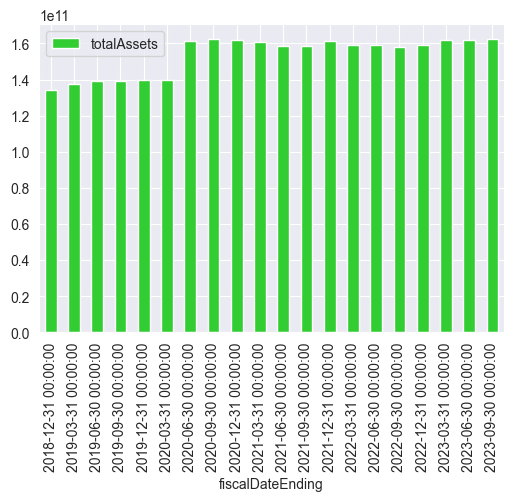

In [23]:
plot_total_assets = quarterly_balance_sheet_statements.plot(
    kind='bar',
    y='totalAssets',
    color='limegreen',
    figsize=(6, 4),
    use_index=True
)

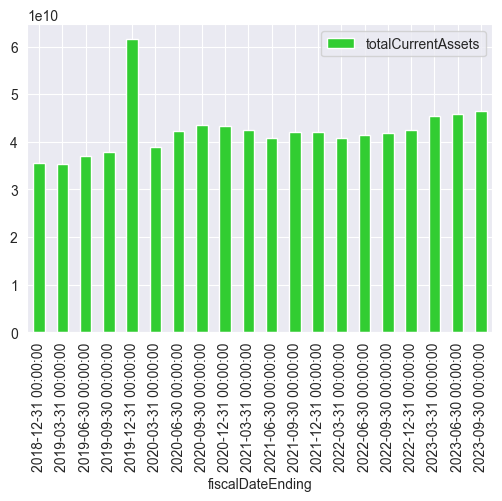

In [24]:
plot_total_current_assets = quarterly_balance_sheet_statements.plot(
    kind='bar',
    y='totalCurrentAssets',
    color='limegreen',
    figsize=(6, 4),
    use_index=True
)

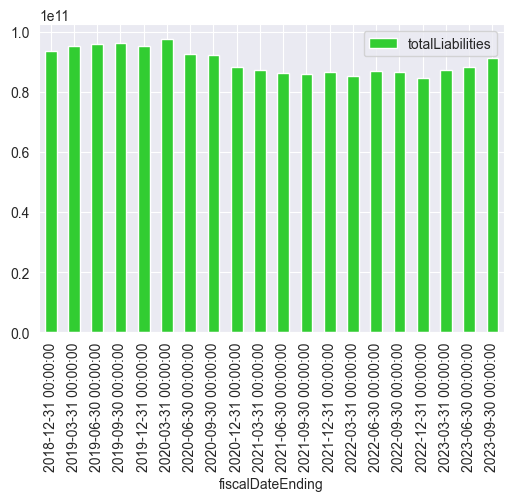

In [25]:
plot_totalLiabilities = quarterly_balance_sheet_statements.plot(
    kind='bar',
    y='totalLiabilities',
    color='limegreen',
    figsize=(6, 4),
    use_index=True
)

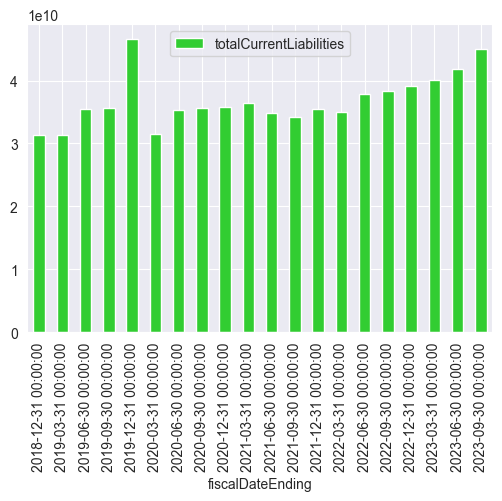

In [26]:
plot_totalCurrentLiabilities = quarterly_balance_sheet_statements.plot(
    kind='bar',
    y='totalCurrentLiabilities',
    color='limegreen',
    figsize=(6, 4),
    use_index=True
)

/var/folders/4_/6kjv3ltd50q381qfm5bjrbqh0000gn/T/ipykernel_34454/3329918508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_balance_sheet_statements['Debt To Equity Ratio'] = annual_balance_sheet_statements['totalLiabilities'] / \


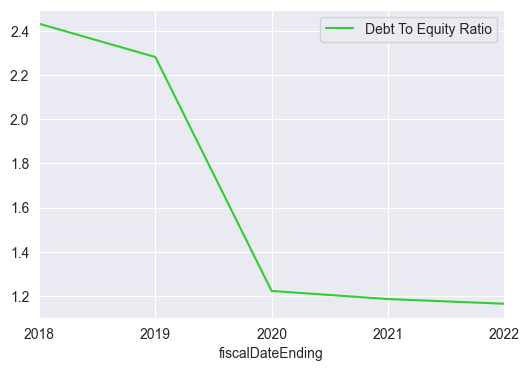

In [27]:
annual_balance_sheet_statements['Debt To Equity Ratio'] = annual_balance_sheet_statements['totalLiabilities'] / \
                                                          annual_balance_sheet_statements['totalShareholderEquity']
plot_debtToEquityRatio = annual_balance_sheet_statements.plot(
    kind='line',
    y='Debt To Equity Ratio',
    color='limegreen',
    figsize=(6, 4),
    use_index=True
)

/var/folders/4_/6kjv3ltd50q381qfm5bjrbqh0000gn/T/ipykernel_34454/2122115617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_balance_sheet_statements['Current Ratio'] = annual_balance_sheet_statements['totalCurrentAssets'] / \


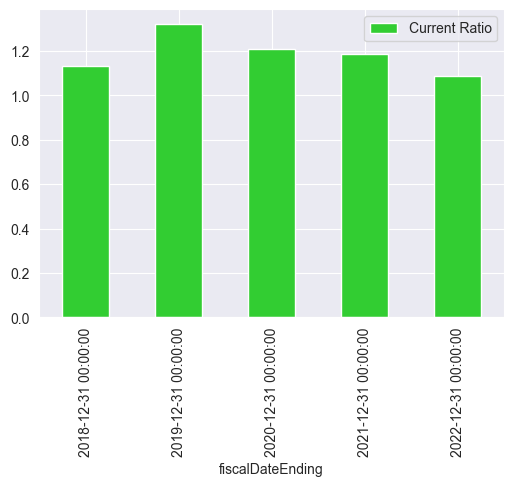

In [28]:
annual_balance_sheet_statements['Current Ratio'] = annual_balance_sheet_statements['totalCurrentAssets'] / \
                                                   annual_balance_sheet_statements['totalCurrentLiabilities']
plot_currentRatio = annual_balance_sheet_statements.plot(
    kind='bar',
    y='Current Ratio',
    color='limegreen',
    figsize=(6, 4),
    use_index=True
)

#### CASHFLOW

In [29]:
cash_flow_df = pd.DataFrame(cash_data)
cash_flow_df.set_index('fiscalDateEnding', inplace=True)
cash_flow_df.sample(10)

,symbol,reportedCurrency,operatingCashflow,paymentsForOperatingActivities,proceedsFromOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,...,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome,period
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2020-06-30,RTX,USD,-3.811000e+09,3.000000e+06,0.0,-1.229000e+09,-1.731000e+09,6.000000e+08,4.580000e+08,-7.730000e+08,...,0.0,0.0,-1.522300e+10,0.0,4.000000e+06,0.0,-3.811000e+09,8000000.0,-3.835000e+09,quarterlyReports
2019-09-30,RTX,USD,1.034000e+09,2.230000e+08,0.0,1.160000e+09,1.275000e+09,3.690000e+08,4.440000e+08,7.740000e+08,...,0.0,0.0,1.700000e+07,0.0,-3.900000e+07,0.0,1.034000e+09,-81000000.0,1.148000e+09,quarterlyReports
2022-12-31,RTX,USD,1.748700e+10,1.781000e+09,0.0,2.921000e+09,2.399000e+09,4.108000e+09,2.775000e+09,-4.370000e+08,...,0.0,0.0,1.000000e+06,0.0,-2.783000e+09,0.0,-1.520000e+09,0.0,5.197000e+09,annualReports
2018-12-31,RTX,USD,4.297000e+09,1.102000e+09,0.0,-7.060000e+08,-5.940000e+08,1.216000e+09,3.450000e+08,-1.232000e+09,...,0.0,0.0,4.600000e+07,0.0,-2.140000e+08,0.0,4.297000e+09,-9000000.0,6.860000e+08,quarterlyReports
2021-03-31,RTX,USD,5.110000e+08,7.000000e+06,0.0,4.820000e+08,1.416000e+09,5.960000e+08,3.870000e+08,7.990000e+08,...,0.0,0.0,0.000000e+00,0.0,-3.740000e+08,0.0,-4.230000e+08,23000000.0,7.530000e+08,quarterlyReports
2021-12-31,RTX,USD,9.351000e+09,1.858000e+09,0.0,1.781000e+09,7.210000e+08,2.737000e+09,1.142000e+09,1.730000e+08,...,0.0,0.0,2.081000e+09,0.0,-3.160000e+08,0.0,6.585000e+09,-11000000.0,6.860000e+08,quarterlyReports
2020-12-31,RTX,USD,2.153000e+09,3.024000e+09,0.0,-2.500000e+07,-5.740000e+08,2.650000e+09,6.230000e+08,-7.510000e+08,...,0.0,0.0,5.000000e+06,0.0,2.400000e+07,0.0,2.153000e+09,43000000.0,1.350000e+08,quarterlyReports
2018-12-31,RTX,USD,1.328400e+10,1.174000e+09,0.0,2.651000e+09,3.406000e+09,1.896000e+09,1.467000e+09,1.147000e+09,...,0.0,0.0,1.345500e+10,0.0,-2.530000e+08,0.0,4.156000e+09,-120000000.0,5.269000e+09,annualReports
2019-06-30,RTX,USD,1.807000e+09,1.920000e+08,0.0,5.400000e+08,5.510000e+08,3.480000e+08,3.150000e+08,1.130000e+08,...,0.0,0.0,2.400000e+07,0.0,-3.400000e+07,0.0,1.807000e+09,-25000000.0,1.900000e+09,quarterlyReports


In [30]:
cash_flow_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2018-12-31 to 2023-09-30
Data columns (total 30 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   symbol                                                     25 non-null     object 
 1   reportedCurrency                                           25 non-null     object 
 2   operatingCashflow                                          25 non-null     float64
 3   paymentsForOperatingActivities                             25 non-null     float64
 4   proceedsFromOperatingActivities                            25 non-null     float64
 5   changeInOperatingLiabilities                               25 non-null     float64
 6   changeInOperatingAssets                                    25 non-null     float64
 7   depreciationDepletionAndAmortization                       25 non-null     float

In [31]:
cash_flow_df.describe()

,operatingCashflow,paymentsForOperatingActivities,proceedsFromOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,changeInInventory,profitLoss,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome
count,2.500000e+01,2.500000e+01,25.0,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,...,2.500000e+01,25.0,25.0,2.500000e+01,25.0,2.500000e+01,25.0,2.500000e+01,2.500000e+01,2.500000e+01
mean,4.558720e+09,8.370400e+08,0.0,7.327200e+08,6.578400e+08,1.431240e+09,8.591200e+08,-6.872000e+07,2.322800e+08,1.300200e+09,...,1.108960e+09,0.0,0.0,1.151400e+09,0.0,-5.389600e+08,0.0,1.663680e+09,-7.920000e+06,1.195280e+09
std,6.154300e+09,1.087322e+09,0.0,1.369099e+09,1.374138e+09,1.356497e+09,6.850857e+08,7.836722e+08,5.194178e+08,2.255516e+09,...,8.234992e+08,0.0,0.0,5.451775e+09,0.0,7.202013e+08,0.0,3.198877e+09,4.315854e+07,2.198217e+09
min,-3.811000e+09,3.000000e+06,0.0,-1.260000e+09,-1.731000e+09,3.480000e+08,3.150000e+08,-1.318000e+09,-5.740000e+08,-3.811000e+09,...,5.640000e+08,0.0,0.0,-1.522300e+10,0.0,-2.783000e+09,0.0,-3.811000e+09,-1.200000e+08,-3.835000e+09
25%,7.190000e+08,7.000000e+06,0.0,-3.660000e+08,-2.970000e+08,4.970000e+08,3.890000e+08,-7.510000e+08,-7.600000e+07,7.720000e+08,...,6.880000e+08,0.0,0.0,0.000000e+00,0.0,-6.310000e+08,0.0,-3.460000e+08,-1.900000e+07,6.860000e+08
50%,1.807000e+09,3.900000e+07,0.0,5.400000e+08,5.510000e+08,6.000000e+08,5.150000e+08,-1.160000e+08,1.410000e+08,1.267000e+09,...,7.510000e+08,0.0,0.0,1.500000e+07,0.0,-3.160000e+08,0.0,8.410000e+08,0.000000e+00,1.148000e+09
75%,5.927000e+09,1.781000e+09,0.0,1.781000e+09,1.275000e+09,2.650000e+09,1.142000e+09,5.960000e+08,4.610000e+08,1.468000e+09,...,8.380000e+08,0.0,0.0,1.981000e+09,0.0,-3.400000e+07,0.0,3.005000e+09,1.500000e+07,1.422000e+09
max,1.859000e+10,3.088000e+09,0.0,3.745000e+09,3.406000e+09,4.557000e+09,2.775000e+09,1.346000e+09,1.575000e+09,5.948000e+09,...,3.128000e+09,0.0,0.0,1.720700e+10,0.0,2.400000e+07,0.0,1.091500e+10,5.600000e+07,5.537000e+09


In [32]:
cash_flow_df.loc[:, (cash_flow_df != 0).any(axis=0)]

,symbol,reportedCurrency,operatingCashflow,paymentsForOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,changeInInventory,...,paymentsForRepurchaseOfCommonStock,paymentsForRepurchaseOfEquity,dividendPayout,dividendPayoutCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromRepurchaseOfEquity,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome,period
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2018-12-31,RTX,USD,1.328400e+10,1.174000e+09,2.651000e+09,3.406000e+09,1.896000e+09,1.467000e+09,1.147000e+09,4.170000e+08,...,3.250000e+08,3.250000e+08,2.170000e+09,2.170000e+09,1.345500e+10,-2.530000e+08,4.156000e+09,-120000000.0,5.269000e+09,annualReports
2018-12-31,RTX,USD,4.297000e+09,1.102000e+09,-7.060000e+08,-5.940000e+08,1.216000e+09,3.450000e+08,-1.232000e+09,-5.740000e+08,...,2.530000e+08,2.530000e+08,5.640000e+08,5.640000e+08,4.600000e+07,-2.140000e+08,4.297000e+09,-9000000.0,6.860000e+08,quarterlyReports
2019-03-31,RTX,USD,2.107000e+09,3.200000e+07,-2.170000e+08,2.280000e+08,3.740000e+08,3.630000e+08,-8.490000e+08,6.970000e+08,...,2.900000e+07,2.900000e+07,6.090000e+08,6.090000e+08,3.200000e+07,-2.400000e+07,6.770000e+08,41000000.0,1.346000e+09,quarterlyReports
2019-06-30,RTX,USD,1.807000e+09,1.920000e+08,5.400000e+08,5.510000e+08,3.480000e+08,3.150000e+08,1.130000e+08,9.800000e+07,...,4.000000e+07,4.000000e+07,6.100000e+08,6.100000e+08,2.400000e+07,-3.400000e+07,1.807000e+09,-25000000.0,1.900000e+09,quarterlyReports
2019-09-30,RTX,USD,1.034000e+09,2.230000e+08,1.160000e+09,1.275000e+09,3.690000e+08,4.440000e+08,7.740000e+08,4.610000e+08,...,4.200000e+07,4.200000e+07,6.110000e+08,6.110000e+08,1.700000e+07,-3.900000e+07,1.034000e+09,-81000000.0,1.148000e+09,quarterlyReports
2019-12-31,RTX,USD,1.859000e+10,2.665000e+09,1.588000e+09,1.007000e+09,2.708000e+09,1.868000e+09,-8.800000e+07,1.267000e+09,...,1.510000e+08,1.510000e+08,2.442000e+09,2.442000e+09,8.800000e+07,-9.700000e+07,1.091500e+10,-19000000.0,5.537000e+09,annualReports
2019-12-31,RTX,USD,4.817000e+09,2.016000e+09,1.050000e+08,-1.047000e+09,1.617000e+09,7.460000e+08,-1.260000e+08,1.100000e+07,...,4.000000e+07,4.000000e+07,6.120000e+08,6.120000e+08,1.500000e+07,0.000000e+00,4.817000e+09,46000000.0,1.143000e+09,quarterlyReports
2020-03-31,RTX,USD,3.200000e+07,3.900000e+07,3.500000e+07,9.220000e+08,3.540000e+08,3.250000e+08,-3.900000e+08,3.950000e+08,...,4.700000e+07,4.700000e+07,6.140000e+08,6.140000e+08,1.720700e+10,-4.100000e+07,1.700000e+07,-94000000.0,-8.300000e+07,quarterlyReports
2020-06-30,RTX,USD,-3.811000e+09,3.000000e+06,-1.229000e+09,-1.731000e+09,6.000000e+08,4.580000e+08,-7.730000e+08,1.550000e+08,...,0.000000e+00,0.000000e+00,7.240000e+08,7.240000e+08,-1.522300e+10,4.000000e+06,-3.811000e+09,8000000.0,-3.835000e+09,quarterlyReports


In [33]:
annual_cash_flow_statements = cash_flow_df[cash_flow_df['period'] == 'annualReports']
quarterly_cash_flow_statements = cash_flow_df[cash_flow_df['period'] == 'quarterlyReports']

In [34]:
annual_cash_flow_statements

,symbol,reportedCurrency,operatingCashflow,paymentsForOperatingActivities,proceedsFromOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,...,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome,period
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2018-12-31,RTX,USD,1.328400e+10,1.174000e+09,0.0,2.651000e+09,3.406000e+09,1.896000e+09,1.467000e+09,1.147000e+09,...,0.0,0.0,1.345500e+10,0.0,-2.530000e+08,0.0,4.156000e+09,-120000000.0,5.269000e+09,annualReports
2019-12-31,RTX,USD,1.859000e+10,2.665000e+09,0.0,1.588000e+09,1.007000e+09,2.708000e+09,1.868000e+09,-8.800000e+07,...,0.0,0.0,8.800000e+07,0.0,-9.700000e+07,0.0,1.091500e+10,-19000000.0,5.537000e+09,annualReports
2020-12-31,RTX,USD,5.927000e+09,3.088000e+09,0.0,-5.370000e+08,-1.348000e+09,4.156000e+09,1.795000e+09,-1.318000e+09,...,0.0,0.0,2.004000e+09,0.0,-1.700000e+07,0.0,3.005000e+09,-22000000.0,-3.519000e+09,annualReports
2021-12-31,RTX,USD,1.509200e+10,1.905000e+09,0.0,2.289000e+09,2.567000e+09,4.557000e+09,2.322000e+09,5.700000e+08,...,0.0,0.0,4.062000e+09,0.0,-2.313000e+09,0.0,7.042000e+09,-1000000.0,3.864000e+09,annualReports
2022-12-31,RTX,USD,1.748700e+10,1.781000e+09,0.0,2.921000e+09,2.399000e+09,4.108000e+09,2.775000e+09,-4.370000e+08,...,0.0,0.0,1.000000e+06,0.0,-2.783000e+09,0.0,-1.520000e+09,0.0,5.197000e+09,annualReports


In [35]:
quarterly_cash_flow_statements

,symbol,reportedCurrency,operatingCashflow,paymentsForOperatingActivities,proceedsFromOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,...,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome,period
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2018-12-31,RTX,USD,4.297000e+09,1.102000e+09,0.0,-7.060000e+08,-5.940000e+08,1.216000e+09,3.450000e+08,-1.232000e+09,...,0.0,0.0,4.600000e+07,0.0,-2.140000e+08,0.0,4.297000e+09,-9000000.0,6.860000e+08,quarterlyReports
2019-03-31,RTX,USD,2.107000e+09,3.200000e+07,0.0,-2.170000e+08,2.280000e+08,3.740000e+08,3.630000e+08,-8.490000e+08,...,0.0,0.0,3.200000e+07,0.0,-2.400000e+07,0.0,6.770000e+08,41000000.0,1.346000e+09,quarterlyReports
2019-06-30,RTX,USD,1.807000e+09,1.920000e+08,0.0,5.400000e+08,5.510000e+08,3.480000e+08,3.150000e+08,1.130000e+08,...,0.0,0.0,2.400000e+07,0.0,-3.400000e+07,0.0,1.807000e+09,-25000000.0,1.900000e+09,quarterlyReports
2019-09-30,RTX,USD,1.034000e+09,2.230000e+08,0.0,1.160000e+09,1.275000e+09,3.690000e+08,4.440000e+08,7.740000e+08,...,0.0,0.0,1.700000e+07,0.0,-3.900000e+07,0.0,1.034000e+09,-81000000.0,1.148000e+09,quarterlyReports
2019-12-31,RTX,USD,4.817000e+09,2.016000e+09,0.0,1.050000e+08,-1.047000e+09,1.617000e+09,7.460000e+08,-1.260000e+08,...,0.0,0.0,1.500000e+07,0.0,0.000000e+00,0.0,4.817000e+09,46000000.0,1.143000e+09,quarterlyReports
2020-03-31,RTX,USD,3.200000e+07,3.900000e+07,0.0,3.500000e+07,9.220000e+08,3.540000e+08,3.250000e+08,-3.900000e+08,...,0.0,0.0,1.720700e+10,0.0,-4.100000e+07,0.0,1.700000e+07,-94000000.0,-8.300000e+07,quarterlyReports
2020-06-30,RTX,USD,-3.811000e+09,3.000000e+06,0.0,-1.229000e+09,-1.731000e+09,6.000000e+08,4.580000e+08,-7.730000e+08,...,0.0,0.0,-1.522300e+10,0.0,4.000000e+06,0.0,-3.811000e+09,8000000.0,-3.835000e+09,quarterlyReports
2020-09-30,RTX,USD,2.980000e+08,8.000000e+06,0.0,6.820000e+08,3.500000e+07,5.990000e+08,3.890000e+08,5.960000e+08,...,0.0,0.0,1.500000e+07,0.0,-4.000000e+06,0.0,2.980000e+08,21000000.0,2.640000e+08,quarterlyReports
2020-12-31,RTX,USD,2.153000e+09,3.024000e+09,0.0,-2.500000e+07,-5.740000e+08,2.650000e+09,6.230000e+08,-7.510000e+08,...,0.0,0.0,5.000000e+06,0.0,2.400000e+07,0.0,2.153000e+09,43000000.0,1.350000e+08,quarterlyReports


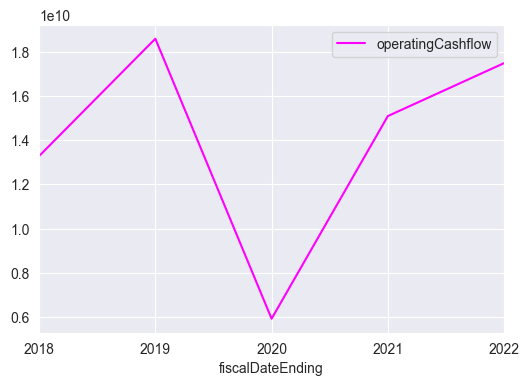

In [36]:
plot_operatingCashFlow = annual_cash_flow_statements.plot(
    kind='line',
    y='operatingCashflow',
    color='fuchsia',
    figsize=(6, 4),
    use_index=True
)

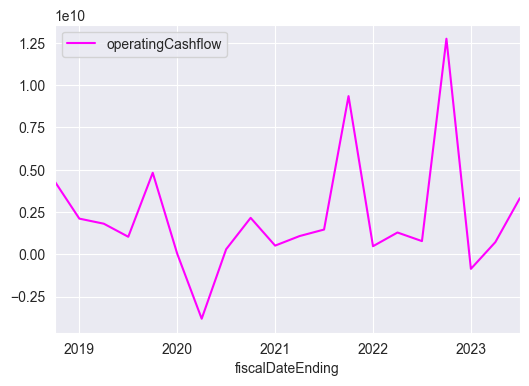

In [37]:
plot_operating_Cash_Flow_quaterly = quarterly_cash_flow_statements.plot(
    kind='line',
    y='operatingCashflow',
    color='fuchsia',
    figsize=(6, 4),
    use_index=True
)

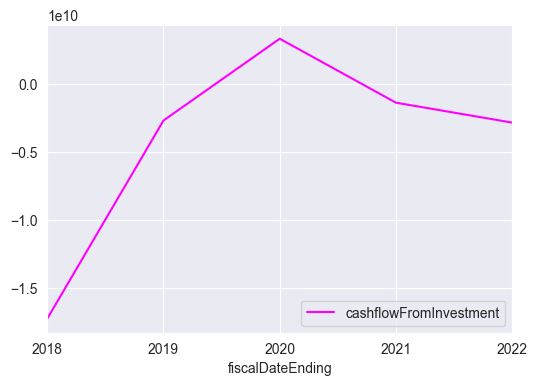

In [38]:
plot_Cash_Flow_From_Investment = annual_cash_flow_statements.plot(
    kind='line',
    y='cashflowFromInvestment',
    color='fuchsia',
    figsize=(6, 4),
    use_index=True
)

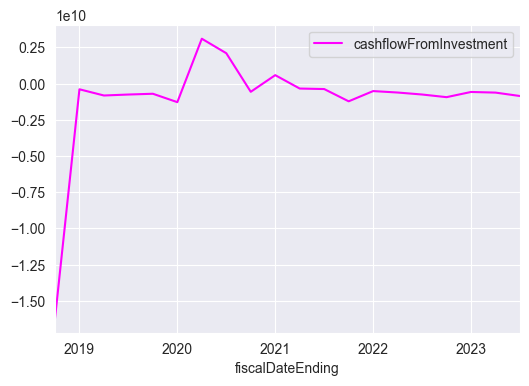

In [39]:
plot_Cash_Flow_From_Investment_quarterly = quarterly_cash_flow_statements.plot(
    kind='line',
    y='cashflowFromInvestment',
    color='fuchsia',
    figsize=(6, 4),
    use_index=True
)

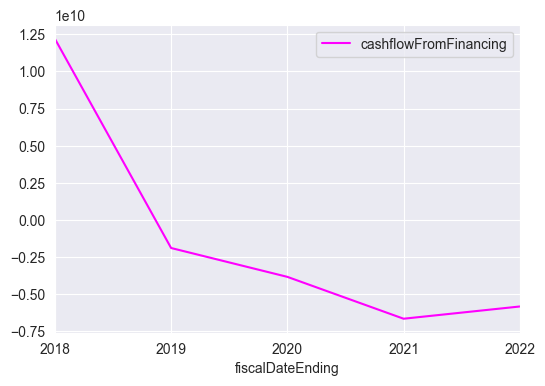

In [40]:
plot_Cash_Flow_From_Financing = annual_cash_flow_statements.plot(
    kind='line',
    y='cashflowFromFinancing',
    color='fuchsia',
    figsize=(6, 4),
    use_index=True
)

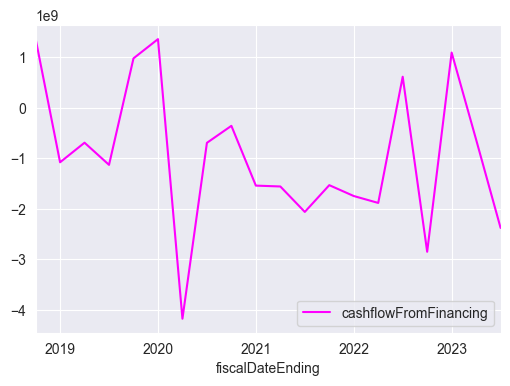

In [41]:
plot_Cash_Flow_From_Financing_quarterly = quarterly_cash_flow_statements.plot(
    kind='line',
    y='cashflowFromFinancing',
    color='fuchsia',
    figsize=(6, 4),
    use_index=True
)

#### EARNINGS Data Probing

In [42]:
earnings_df = pd.DataFrame(earnings_data)
earnings_df.set_index('fiscalDateEnding', inplace=True)
earnings_df.sample(10)

,symbol,reportedEPS,reportedDate,estimatedEPS,surprise,surprisePercentage,period
fiscalDateEnding,,,,,,,
2006-12-31,RTX,3.71,None,0.00,0.00,0.0000,annualEarnings
2008-12-31,RTX,4.91,None,0.00,0.00,0.0000,annualEarnings
2022-12-31,RTX,4.79,None,0.00,0.00,0.0000,annualEarnings
2021-09-30,RTX,1.26,2021-10-26,1.08,0.18,16.6667,quarterlyEarnings
2012-09-30,RTX,1.37,2012-10-23,1.18,0.19,16.1017,quarterlyEarnings
2017-12-31,RTX,1.60,2018-01-24,1.56,0.04,2.5641,quarterlyEarnings
2005-06-30,RTX,0.95,2005-07-20,0.85,0.10,11.7647,quarterlyEarnings
2001-12-31,RTX,0.35,2002-01-17,0.33,0.02,6.0606,quarterlyEarnings
2008-12-31,RTX,1.23,2009-01-21,1.22,0.01,0.8197,quarterlyEarnings


In [43]:
earnings_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 1996-03-31 to 2023-09-30
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   symbol              139 non-null    object 
 1   reportedEPS         139 non-null    float64
 2   reportedDate        111 non-null    object 
 3   estimatedEPS        139 non-null    float64
 4   surprise            139 non-null    float64
 5   surprisePercentage  139 non-null    float64
 6   period              139 non-null    object 
dtypes: float64(4), object(3)
memory usage: 8.7+ KB


In [44]:
earnings_df = earnings_df.dropna()
earnings_df.isna().sum()

symbol                0
reportedEPS           0
reportedDate          0
estimatedEPS          0
surprise              0
surprisePercentage    0
period                0
dtype: int64

In [45]:
earnings_df.describe()

,reportedEPS,estimatedEPS,surprise,surprisePercentage
count,111.000000,111.000000,111.000000,111.000000
mean,1.045405,0.989189,0.056216,6.712382
std,0.545580,0.505627,0.088411,23.071010
min,0.160000,0.120000,-0.150000,-46.666700
25%,0.575000,0.560000,0.010000,1.951650
50%,1.080000,1.030000,0.020000,3.389800
75%,1.460000,1.400000,0.080000,6.558150
max,2.210000,2.050000,0.560000,233.333300


# MACHINE LEARNING MODELS

## Data Cleanup and Merger

In [46]:
def data_analysis(quarterly_income_statements, quarterly_balance_sheet_statements, quarterly_cash_flow_statements,
                  quarterly_earnings_statements):
    income_balance_df = pd.merge(quarterly_income_statements, quarterly_balance_sheet_statements, how='outer',
                                 left_index=True, right_index=True, suffixes=('', '_y'))
    # remove duplicate columns (E.g. symbols would be found in both dataframes, but we only need one)
    income_balance_df.drop(income_balance_df.filter(regex='_y$').columns, axis=1, inplace=True)

    income_balance_cash_df = pd.merge(income_balance_df, quarterly_cash_flow_statements, how='outer', left_index=True,
                                      right_index=True, suffixes=('', '_y'))
    income_balance_cash_df.drop(income_balance_cash_df.filter(regex='_y$').columns, axis=1, inplace=True)

    earnings_df['period'].replace('quarterlyEarnings', 'quarterlyReports', inplace=True)
    earnings_df['period'].replace('annualEarnings', 'annualReports', inplace=True)

    fundamentals_df = pd.merge(income_balance_cash_df, quarterly_earnings_statements, how='outer', left_index=True,
                               right_index=True, suffixes=('', '_y'))
    fundamentals_df.drop(fundamentals_df.filter(regex='_y$').columns, axis=1, inplace=True)

    # remove columns that are of no use to building model
    fundamentals_df.drop(['period', 'reportedCurrency', 'reportedDate', 'report_type'], axis=1, inplace=True)
    # need buffer for gap dates
    max_gap_days = 7
    tick_df = yf.download(ticker, fundamentals_df.index[0], fundamentals_df.index[-1] + timedelta(days=max_gap_days),
                          interval='1d')

    tick_cleaned_df = tick_df[tick_df.index.isin(fundamentals_df.index)]
    missing_dates = fundamentals_df[~fundamentals_df.index.isin(tick_cleaned_df.index)].index

    for missing_date in missing_dates:
        i = 1

        while i < max_gap_days:
            new_date = missing_date + timedelta(days=i)
            if new_date in tick_df.index:
                row = tick_df.loc[new_date]
                row.name = missing_date
                tick_cleaned_df = pd.concat([tick_cleaned_df, pd.DataFrame([row])])
                break
            i += 1

    tick_cleaned_df = tick_cleaned_df.sort_index()
    tick_cleaned_df.index.rename('fiscalDateEnding', inplace=True)
    tick_cleaned_df['invest'] = np.zeros((len(tick_cleaned_df), 1), dtype=np.int8)

    # Check if you should invest in the current quarter, based on the stock price movement in the next quarter
    for i in range(1, len(tick_cleaned_df)):
        index1 = tick_cleaned_df.index[i - 1]
        index2 = tick_cleaned_df.index[i]
        if tick_cleaned_df.loc[index2, 'Adj Close'] >= tick_cleaned_df.loc[index1, 'Adj Close']:
            tick_cleaned_df.at[index1, 'invest'] = 1

    fundamentals_df['invest'] = tick_cleaned_df['invest']
    return fundamentals_df


def get_full_fundamental_dataset():
    symbols_data = stock_repo.find_all(limit=1_000_000)
    dfs = []
    for info in symbols_data:
        ticker = info['symbol']
        income_data = income_statement_repo.find_all(symbol=ticker, limit=1_000_000)
        balance_data = balance_sheet_repo.find_all(symbol=ticker, limit=1_000_000)
        cash_data = cash_flow_repo.find_all(symbol=ticker, limit=1_000_000)
        earnings_data = earnings_repo.find_all(symbol=ticker, limit=1_000_000)

        income_df = pd.DataFrame(income_data).dropna()
        balance_df = pd.DataFrame(balance_data).dropna()
        cash_df = pd.DataFrame(cash_data).dropna()
        earnings_df = pd.DataFrame(earnings_data).dropna()
        
        if len(income_df) < 5 or len(balance_df) < 5 or len(cash_df) < 5 or len(earnings_df) < 5:
            continue

        income_df['fiscalDate'] = income_df['fiscalDateEnding']

        income_df.set_index('fiscalDateEnding', inplace=True)
        balance_df.set_index('fiscalDateEnding', inplace=True)
        cash_df.set_index('fiscalDateEnding', inplace=True)
        earnings_df.set_index('fiscalDateEnding', inplace=True)

        quarterly_income_statements = income_df[income_df['report_type'] == 'quarterlyReports']
        quarterly_earnings_statements = earnings_df[earnings_df['period'] == 'quarterlyEarnings']
        quarterly_cash_flow_statements = cash_flow_df[cash_flow_df['period'] == 'quarterlyReports']
        quarterly_balance_sheet_statements = balance_sheet_df[balance_sheet_df['period'] == 'quarterlyReports']

        dfs.append(data_analysis(quarterly_income_statements, quarterly_balance_sheet_statements,
                                 quarterly_cash_flow_statements, quarterly_earnings_statements))
    return pd.concat(dfs, ignore_index=True).dropna()

In [47]:
full_df = get_full_fundamental_dataset()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [48]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1719 entries, 80 to 5816
Data columns (total 93 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   symbol                                                     1719 non-null   object        
 1   grossProfit                                                1719 non-null   float64       
 2   totalRevenue                                               1719 non-null   float64       
 3   costOfRevenue                                              1719 non-null   float64       
 4   costofGoodsAndServicesSold                                 1719 non-null   float64       
 5   operatingIncome                                            1719 non-null   float64       
 6   sellingGeneralAndAdministrative                            1719 non-null   float64       
 7   researchAndDevelopment               

## Dummy Variables for Supervised Classification

In [49]:
one_hot = pd.get_dummies(full_df['symbol'])
ml_df = full_df.drop('symbol', axis=1).join(one_hot)
ml_df['date'] = (ml_df['fiscalDate'] - datetime(1970, 1, 1)).dt.total_seconds()

ml_df.drop(['fiscalDate'], axis=1, inplace=True)

In [50]:
list(full_df['symbol'].unique())

['AA',
 'AAC',
 'AACG',
 'AACI',
 'AAL',
 'ADIL',
 'ADM',
 'AGCO',
 'AGE',
 'AGEN',
 'AGFY',
 'AGRX',
 'AGS',
 'AGTI',
 'AHH',
 'AHI',
 'ALL',
 'ALLE',
 'AMPL',
 'AMPS',
 'AMPX',
 'AMPY',
 'AMR',
 'APLT',
 'APM',
 'APO',
 'ARL',
 'ARLO',
 'ARLP',
 'ARMK',
 'ASX',
 'ASXC',
 'ASYS',
 'ATAI',
 'ATAK',
 'ATCOL',
 'ATEC',
 'ATEK',
 'AVGR',
 'AVHI',
 'BACK',
 'BAER',
 'BAFN',
 'BAH',
 'BGLC',
 'BGNE',
 'BKD',
 'BN',
 'CAPL',
 'CAPR',
 'CAR',
 'CARA',
 'CHK',
 'CRON',
 'CROX',
 'CRS',
 'CRSP',
 'CRT',
 'DBVT',
 'DBX',
 'DC',
 'DUNE',
 'DUO',
 'DUOL',
 'DVN',
 'EQT',
 'EQX',
 'FNKO',
 'FNLC',
 'FNV',
 'HSBC',
 'HSDT',
 'IOVA',
 'IP',
 'KIQ',
 'KITT',
 'MTB',
 'MTBL',
 'MTC',
 'MTCH',
 'MTD',
 'MTDR',
 'NVEC',
 'NVEE',
 'NVEI',
 'NVFY',
 'PECO',
 'PED',
 'PEG',
 'PEGA',
 'PEGR',
 'PEGY',
 'QRHC',
 'QRTEA',
 'QRTEB',
 'RTX',
 'SOBR',
 'SOFI',
 'SOFO',
 'SOHO',
 'TDOC',
 'UNB',
 'UNCY']

In [51]:
ml_df.head()

,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,netInterestIncome,...,QRTEB,RTX,SOBR,SOFI,SOFO,SOHO,TDOC,UNB,UNCY,date
80,3.206000e+09,3.344000e+09,1.380000e+08,2.513000e+09,3.068000e+09,59000000.0,7000000.0,1.380000e+08,0.0,-31000000.0,...,False,False,False,False,False,False,False,False,False,1.546214e+09
81,2.308000e+09,2.677000e+09,3.690000e+08,2.180000e+09,1.920000e+09,84000000.0,7000000.0,3.880000e+08,0.0,-30000000.0,...,False,False,False,False,False,False,False,False,False,1.553990e+09
82,2.608000e+09,2.676000e+09,6.800000e+07,2.189000e+09,2.526000e+09,68000000.0,7000000.0,8.200000e+07,0.0,-30000000.0,...,False,False,False,False,False,False,False,False,False,1.561853e+09
83,3.200000e+08,2.538000e+09,2.218000e+09,2.120000e+09,2.200000e+08,66000000.0,7000000.0,1.000000e+08,0.0,-30000000.0,...,False,False,False,False,False,False,False,False,False,1.569802e+09
84,2.436000e+09,2.436000e+09,3.071000e+09,2.048000e+09,2.436000e+09,62000000.0,6000000.0,1.032000e+09,0.0,-31000000.0,...,False,False,False,False,False,False,False,False,False,1.577750e+09


In [52]:
Y = ml_df['invest']
ml_df.drop(['invest'], axis=1, inplace=True)

## Training and Prediction

In [53]:
X_train, X_test, y_train, y_test = train_test_split(ml_df, Y, test_size=0.33, random_state=42)

In [54]:
clf1 = LogisticRegression(random_state=0).fit(X_train, y_train)
clf2 = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
score1 = clf1.score(X_test, y_test)
score2 = clf2.score(X_test, y_test)

In [55]:
score1, score2

(1.0, 1.0)

In [56]:
predictions1 = clf1.predict(X_test)
predictions2 = clf2.predict(X_test)
cm1 = metrics.confusion_matrix(y_test, predictions1)
cm2 = metrics.confusion_matrix(y_test, predictions2)


<Axes: >

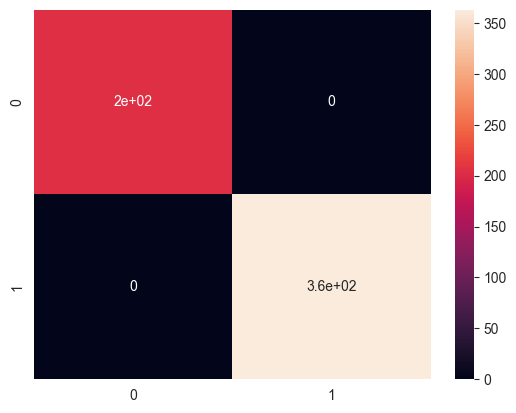

In [57]:
sns.heatmap(cm1, annot=True)

<Axes: >

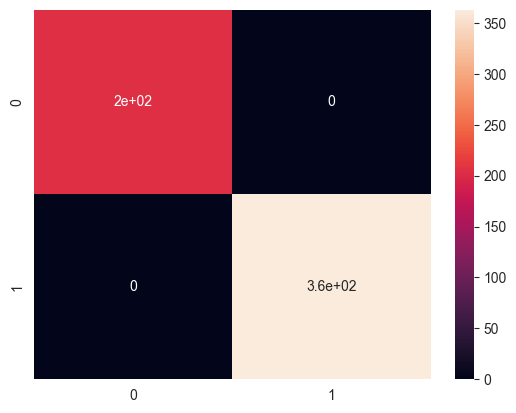

In [58]:
sns.heatmap(cm2, annot=True)

## Saving Models

In [59]:
data_path = os.path.join(os.path.abspath(os.curdir), '..', 'data')
with open(os.path.join(data_path, 'dtree_model.ml'), 'wb') as file:
    pickle.dump(clf2, file)

with open(os.path.join(data_path, 'logistic_model.ml'), 'wb') as file:
    pickle.dump(clf1, file)

with open(os.path.join(data_path, 'feature_symbols.binary'), 'wb') as file:
    pickle.dump(list(col for col in X_train.columns if col in full_df['symbol'].values), file)

In [60]:
ml_df.head()

,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,netInterestIncome,...,QRTEB,RTX,SOBR,SOFI,SOFO,SOHO,TDOC,UNB,UNCY,date
80,3.206000e+09,3.344000e+09,1.380000e+08,2.513000e+09,3.068000e+09,59000000.0,7000000.0,1.380000e+08,0.0,-31000000.0,...,False,False,False,False,False,False,False,False,False,1.546214e+09
81,2.308000e+09,2.677000e+09,3.690000e+08,2.180000e+09,1.920000e+09,84000000.0,7000000.0,3.880000e+08,0.0,-30000000.0,...,False,False,False,False,False,False,False,False,False,1.553990e+09
82,2.608000e+09,2.676000e+09,6.800000e+07,2.189000e+09,2.526000e+09,68000000.0,7000000.0,8.200000e+07,0.0,-30000000.0,...,False,False,False,False,False,False,False,False,False,1.561853e+09
83,3.200000e+08,2.538000e+09,2.218000e+09,2.120000e+09,2.200000e+08,66000000.0,7000000.0,1.000000e+08,0.0,-30000000.0,...,False,False,False,False,False,False,False,False,False,1.569802e+09
84,2.436000e+09,2.436000e+09,3.071000e+09,2.048000e+09,2.436000e+09,62000000.0,6000000.0,1.032000e+09,0.0,-31000000.0,...,False,False,False,False,False,False,False,False,False,1.577750e+09
